In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
# !cp /content/drive/MyDrive/The\ School\ of\ AI/Session\ 6\ Assignment/model.py /content
# !cp /content/drive/MyDrive/The\ School\ of\ AI/Session\ 6\ Assignment/utils.py /content

In [ ]:
# import model
# import utils
# from model import Net
# from utils import *

In [ ]:
# Train data transformations
train_transforms = transforms.Compose([
    #transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    #transforms.RandomAffine(degrees = 0, translate = (0.2, 0.2)), # apply shift
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.1407,), (0.4081,)) --> This is incorrect line and hence commented
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [ ]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
#test_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms) --> Commented the incorrect line. train = False and test_transform needs to be passed
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

In [ ]:
type(train_data), len(train_data), len(train_data[0]), train_data.data.shape, test_data.data.shape

(torchvision.datasets.mnist.MNIST,
 60000,
 2,
 torch.Size([60000, 28, 28]),
 torch.Size([10000, 28, 28]))

In [ ]:
batch_size = 128

#kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True} --> Commented the incorrect line. shuffle parameter needs to be True
kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

#test_loader = torch.utils.data.DataLoader(train_data, **kwargs) --> Commented the incorrect line. test_data needs be passed for test_loader
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

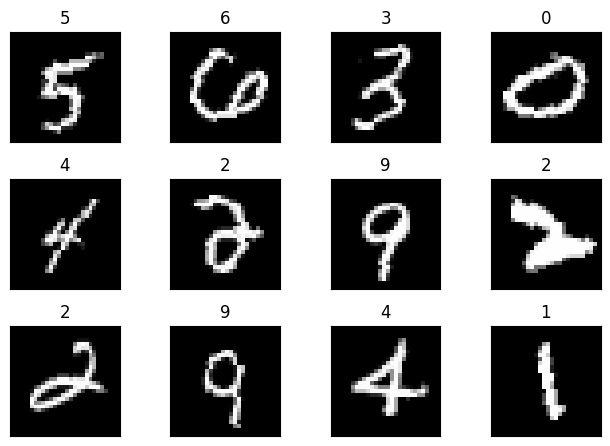

In [ ]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [ ]:
from tqdm import tqdm

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

This was original structure in assignment 6 submission

In [ ]:
# class Net(nn.Module):
#     #This defines the structure of the NN.
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(1, 128, 3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(128),
#             nn.Dropout(0.1)
#         ) # 28*28*128

#         self.trans1 = nn.Sequential(
#             nn.Conv2d(128, 8, 1, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(8),
#             nn.Dropout(0.1)
#         ) # 30*30*8

#         self.conv2 = nn.Sequential(
#             nn.Conv2d(8, 16, 3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(0.1),
#             nn.MaxPool2d(2, 2)
#         ) # 30*30*16 | 15*15*16

#         self.conv3 = nn.Sequential(
#             nn.Conv2d(16, 16, 3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(0.1)
#         ) # 15*15*16

#         self.conv4 = nn.Sequential(
#             nn.Conv2d(16, 32, 3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.Dropout(0.1),
#             nn.MaxPool2d(2, 2)
#         ) # 15*15*32 | 7*7*32

#         self.trans2 = nn.Sequential(
#             nn.Conv2d(32, 16, 1, padding=1)
#         ) # 9*9*32

#         self.conv5 = nn.Sequential(
#             nn.Conv2d(16, 16, 3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(0.1)
#         ) # 9**9*16

#         self.conv6 = nn.Sequential(
#             nn.Conv2d(16, 32, 3, padding=1), # 1*1
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.Dropout(0.1)
#         ) # 9*9*32

#         self.conv7 = nn.Sequential(
#             nn.Conv2d(32, 10, 1, padding=1),
#             nn.AvgPool2d(kernel_size=7)
#         ) # 11*11*10 | 1*1*10

#     def forward(self, x):
#       x = self.conv1(x)
#       #print("size after 1st layer: " ,x.shape)
#       x = self.trans1(x)
#       x = self.conv2(x)
#       #print("size after 2nd layer: " ,x.shape)
#       x = self.conv3(x)
#       #print("size after 3rd layer: " ,x.shape)
#       x = self.conv4(x)
#       x = self.trans2(x)
#       x = self.conv5(x)
#       x = self.conv6(x)
#       x = self.conv7(x)
#       #print("size after 4th layer: " ,x.shape)
#       x = x.view(x.size(0), -1)
#       #print("size after flattening: " ,x.shape)
#       x = F.log_softmax(x, dim=1)
#       return x

Modifed structure below

In [ ]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 4, 3, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(4),
            nn.Dropout(0.1)
        ) # 26*26*4

        self.conv2 = nn.Sequential(
            nn.Conv2d(4, 8, 3, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.1),
            nn.MaxPool2d(2, 2)
        ) # 24*24*8 | 12*12*8

        self.trans1 = nn.Sequential(
            nn.Conv2d(8, 8, 1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.1)
        ) # 12*12*8
        # increase it back to 16
        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1)
            #nn.MaxPool2d(2, 2)
        ) # 10*10*16

        self.conv4 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),
            #nn.MaxPool2d(2, 2)
        ) # 8*8*16

        self.trans2 = nn.Sequential(
            nn.Conv2d(32, 8, 1, padding=0) ## bring down to 8
        ) # 8*8*8

        self.conv5 = nn.Sequential(
            nn.Conv2d(8, 8, 3, padding=0), ## take it from 8 to 16
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.1),
            #nn.MaxPool2d(2, 2)
        ) # 6*6*8

        self.conv6 = nn.Sequential(
            nn.Conv2d(8, 10, 3, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.1),
            #nn.MaxPool2d(2, 2)
        ) # 4*4*10

        self.conv7 = nn.Sequential(
            nn.Conv2d(10, 10, 1, padding=0),
            nn.AvgPool2d(kernel_size=4)
        ) # 4*4*10 | 1*1*10

    def forward(self, x):
      x = self.conv1(x)
      #print("size after 1st layer: " ,x.shape)
      x = self.conv2(x)
      x = self.trans1(x)
      x = self.conv3(x)
      #print("size after 2nd layer: " ,x.shape)
      x = self.conv4(x)
      x = self.trans2(x)
      x = self.conv5(x)
      x = self.conv6(x)
      x = self.conv7(x)
      #print("size after 4th layer: " ,x.shape)
      x = x.view(x.size(0), -1)
      #print("size after flattening: " ,x.shape)
      x = F.log_softmax(x, dim=1)
      return x

In [ ]:
def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

In [ ]:
def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    #loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))
  return train_losses, train_acc

In [ ]:
def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            #test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
            #test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_losses, test_acc

In [ ]:
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              40
              ReLU-2            [-1, 4, 26, 26]               0
       BatchNorm2d-3            [-1, 4, 26, 26]               8
           Dropout-4            [-1, 4, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             296
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              72
             ReLU-11            [-1, 8, 12, 12]               0
      BatchNorm2d-12            [-1, 8, 12, 12]              16
          Dropout-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1, 16,

In [ ]:
import torch.optim.lr_scheduler as lrs

In [ ]:
model = Net().to(device)

#optimizer = optim.SGD(model.parameters(), lr=10.01, momentum=0.9) -- Commented the line since learning rate needs to be corrected
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.01)

#scheduler = lrs.ReduceLROnPlateau(optimizer, 'min',patience = 3, verbose=True)
scheduler = lrs.ReduceLROnPlateau(optimizer, 'max',patience = 1, verbose=True)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1, verbose=True)

# New Line
#criterion = nn.CrossEntropyLoss()
num_epochs = 15

In [ ]:
# train_losses, train_acc = train(model, device, train_loader, optimizer)

In [ ]:
# len(train_losses), len(train_acc), train_losses[0]

In [ ]:
for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_losses, train_acc = train(model, device, train_loader, optimizer)

  #test(model, device, train_loader) --> Removed this incorrect line. test_loader needs to be passed here
  test_losses, test_acc = test(model, device, test_loader)

  scheduler.step(test_acc[epoch-1])
  my_lr = optimizer.param_groups[0]['lr']

  print(f'Test accuracy {test_acc[epoch-1]}')
  print(f'Learning Rate {my_lr}')

Epoch 1


Train: Loss=0.2506 Batch_id=468 Accuracy=83.92: 100%|██████████| 469/469 [00:33<00:00, 13.99it/s]


Test set: Average loss: 0.0984, Accuracy: 9731/10000 (97.31%)

Test accuracy 97.31
Learning Rate 0.01
Epoch 2


Train: Loss=0.1515 Batch_id=468 Accuracy=95.48: 100%|██████████| 469/469 [00:23<00:00, 19.59it/s]


Test set: Average loss: 0.0839, Accuracy: 9751/10000 (97.51%)

Test accuracy 97.51
Learning Rate 0.01
Epoch 3


Train: Loss=0.0557 Batch_id=468 Accuracy=96.52: 100%|██████████| 469/469 [00:25<00:00, 18.72it/s]


Test set: Average loss: 0.0556, Accuracy: 9831/10000 (98.31%)

Test accuracy 98.31
Learning Rate 0.01
Epoch 4


Train: Loss=0.0714 Batch_id=468 Accuracy=97.00: 100%|██████████| 469/469 [00:24<00:00, 18.88it/s]


Test set: Average loss: 0.0715, Accuracy: 9778/10000 (97.78%)

Test accuracy 97.78
Learning Rate 0.01
Epoch 5


Train: Loss=0.0800 Batch_id=468 Accuracy=97.31: 100%|██████████| 469/469 [00:26<00:00, 17.72it/s]


Test set: Average loss: 0.0444, Accuracy: 9872/10000 (98.72%)

Test accuracy 98.72
Learning Rate 0.01
Epoch 6


Train: Loss=0.0853 Batch_id=468 Accuracy=97.45: 100%|██████████| 469/469 [00:25<00:00, 18.73it/s]


Test set: Average loss: 0.0331, Accuracy: 9895/10000 (98.95%)

Test accuracy 98.95
Learning Rate 0.01
Epoch 7


Train: Loss=0.0600 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:24<00:00, 18.83it/s]


Test set: Average loss: 0.0337, Accuracy: 9891/10000 (98.91%)

Test accuracy 98.91
Learning Rate 0.01
Epoch 8


Train: Loss=0.0303 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:24<00:00, 19.53it/s]


Test set: Average loss: 0.0370, Accuracy: 9881/10000 (98.81%)

Epoch 00008: reducing learning rate of group 0 to 1.0000e-03.
Test accuracy 98.81
Learning Rate 0.001
Epoch 9


Train: Loss=0.0672 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:23<00:00, 20.28it/s]


Test set: Average loss: 0.0310, Accuracy: 9902/10000 (99.02%)

Test accuracy 99.02
Learning Rate 0.001
Epoch 10


Train: Loss=0.0332 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:23<00:00, 19.74it/s]


Test set: Average loss: 0.0287, Accuracy: 9908/10000 (99.08%)

Test accuracy 99.08
Learning Rate 0.001
Epoch 11


Train: Loss=0.0493 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:24<00:00, 19.08it/s]


Test set: Average loss: 0.0286, Accuracy: 9912/10000 (99.12%)

Test accuracy 99.12
Learning Rate 0.001
Epoch 12


Train: Loss=0.0380 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:24<00:00, 18.87it/s]


Test set: Average loss: 0.0268, Accuracy: 9909/10000 (99.09%)

Test accuracy 99.09
Learning Rate 0.001
Epoch 13


Train: Loss=0.0838 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:24<00:00, 18.96it/s]


Test set: Average loss: 0.0272, Accuracy: 9907/10000 (99.07%)

Epoch 00013: reducing learning rate of group 0 to 1.0000e-04.
Test accuracy 99.07
Learning Rate 0.0001
Epoch 14


Train: Loss=0.0780 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:25<00:00, 18.73it/s]


Test set: Average loss: 0.0276, Accuracy: 9906/10000 (99.06%)

Test accuracy 99.06
Learning Rate 0.0001
Epoch 15


Train: Loss=0.0156 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:23<00:00, 19.82it/s]


Test set: Average loss: 0.0279, Accuracy: 9907/10000 (99.07%)

Epoch 00015: reducing learning rate of group 0 to 1.0000e-05.
Test accuracy 99.07
Learning Rate 1e-05


In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Test Accuracy')

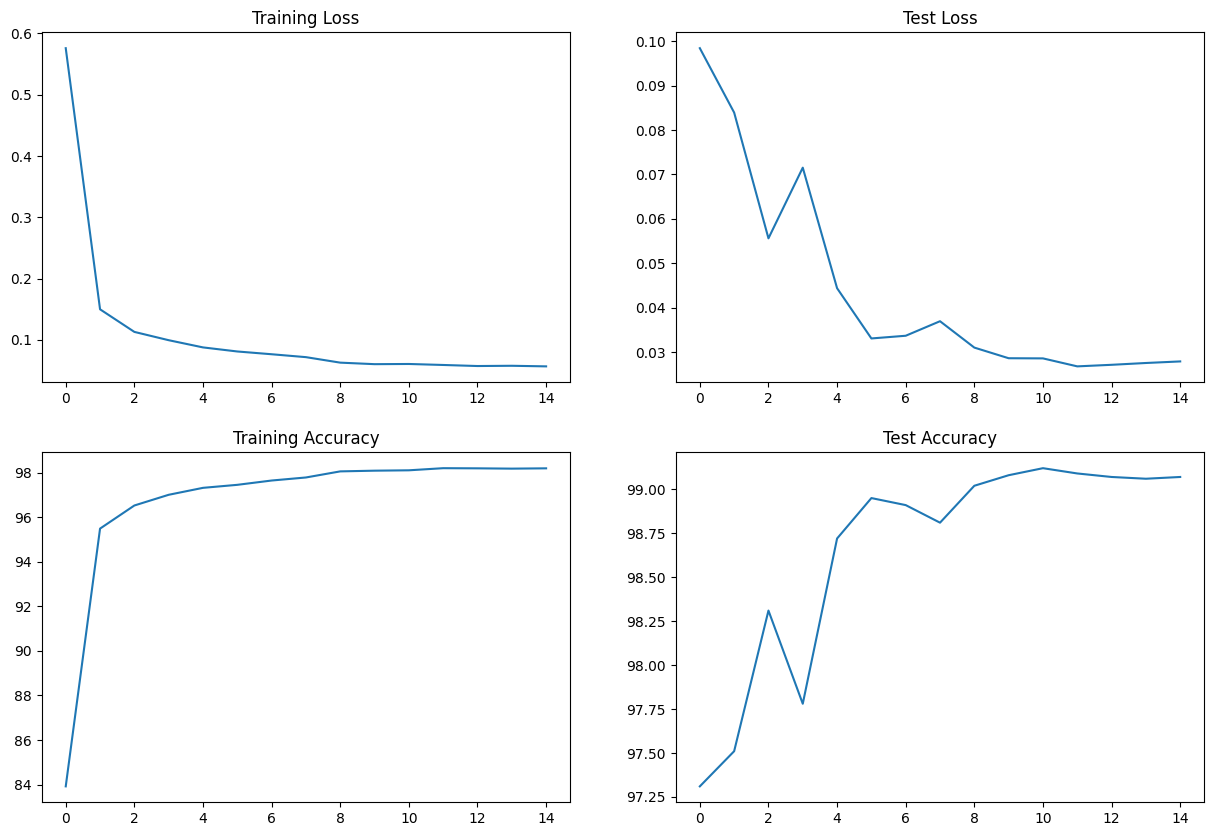

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
# printTrainTest_LossAcc(train_losses,train_acc,test_losses,test_acc)